## Solubility Experiments With Advanced Multiple Regression Algorithms 
##                                    Converted From R to Python   

I completed a course last fall (2023) on Advanced Multiple Regression Algorithms. The course focused on weaknesses that the original linear regression algorithm exhibits when there is high correlation amongst the predictors or when the predictors are greater than the samples (p > n). In the course, we developed models using R language packages.

The course reviewed the following algorithms: Ordinary Linear Regression (OLS), Partial Least Squares (PLS) , Ridge Regression (RR), Least Absolute Shrinkage and Selection Operator (LASSO) Regressoon, Electric Net, Random Forest, and Support Vector Machines (SVM). 

The goal of this notebook is use the same data that we used for that course (a dataset of 1267 compounds with a resposne variable of solubility and 228 characteristics used as predictors), but to develop the solutions using Python.

The models I build will examine the 288 characteristics of a compound and the compound's solubility. I will start by examine this relationship using three algorithms:   a) OLS, b) Lasso, and c) Random Forest regression model.


Model Assessment:

All Three models generated will be evaluated and compared to examine not only how well they perfoorm, but also how well the meet the assumptions of a linear model. Although these assumptions apply only to strict linear models (OLS), I am doing the same tests on the LASSO and Random Forest models to examine the impact of the non-linear models have on the residuals. The measurement methods will be:

a) Performance :
     - R2
     - RMSE
     - MSE
   
b) Model Assumptions:

    - Linearity and Residuals have Mean value of zero (Residual vs Predicted Plot)
    - Residuals are normally distributed ( QQNorm plot and Kolmogorov-Smirnov test)
    - Residuals have constant variance/homoscedasticity ( Breusch-Pagan Test)
    - Residuals are independent values (Durbin-Watsin Test)
    

In [1]:
#import libraries
import numpy as np 
import pandas as pd
import random

In [ ]:
%%cmd
pwd
cd ../HSB/data
ls -la

REM this cell is a place holder to execute OS commands that may be beneficial to the work. 
REM %%cmd must be on 1st line

<div class="alert alert-block alert-info">
    <p style="margin-left: 25px;">
    <b><font size="5">Examine and Cleanup Data</font></b></p><br>
    <font size="3">
         <ol>
          <li>Read Data</li> 
          <li>Check For Normally Distributed Predictors</li>
          <li>Apply BoxCox</li>
         </ol> </font>
</div> 


In [2]:
# read data and examine data types
path = 'E:/Jupyter/notebooks/HSB/data/'
fname = 'Solubility.csv'
full_name = path + fname
solubility_data = pd.read_csv(full_name)
print('solubility dimensions: ',solubility_data.shape)
#solubility_data[1:5]
#solubility_data.dtypes
#fname2 = 'Transformed.csv'
#fullname2 = path + fname2
#transformed_data = pd.read_csv(fullname2)
#print('transformed dimensions: ',solubility_data.shape)

solubility dimensions:  (1267, 230)


<div class="alert alert-block alert-info">
    <p style="margin-left: 25px;">
    <b><font size="5">Find Predictors That Are Not Indicator Variables</font></b></p>
</div>

In [3]:
# Data is made up of indicator predictors (0, 1) and continuous non-indicator predictors 
# Identify all predictors that are not indicator predictors
# https://www.statology.org/pandas-five-number-summary/
# https://stackoverflow.com/questions/57482770/filter-a-dataframe-with-not-and-and-condition
# Find non-indicator predictors
five_number_sol = solubility_data.describe().loc[['min', '25%', '50%', '75%', 'max']].T
non_ind_cols = five_number_sol[(five_number_sol['min'] != 0 ) | (five_number_sol['max'] != 1)]
non_ind_colnames = non_ind_cols.index.values.tolist()[0:len(non_ind_cols)-1]
non_ind_colnames

['MolWeight',
 'NumAtoms',
 'NumNonHAtoms',
 'NumBonds',
 'NumNonHBonds',
 'NumMultBonds',
 'NumRotBonds',
 'NumDblBonds',
 'NumAromaticBonds',
 'NumHydrogen',
 'NumCarbon',
 'NumNitrogen',
 'NumOxygen',
 'NumSulfer',
 'NumChlorine',
 'NumHalogen',
 'NumRings',
 'HydrophilicFactor',
 'SurfaceArea1',
 'SurfaceArea2']

<div class="alert alert-block alert-info">
    <p style="margin-left: 25px;">
    <b><font size="5">Split Data into Training and Test</font></b></p>
</div>

In [4]:
# Split data into training and testing data sets.
# I used the already split data first
# https://www.geeksforgeeks.org/how-to-do-train-test-split-using-sklearn-in-python/

from sklearn.model_selection import train_test_split 
in_data = solubility_data.loc[:, solubility_data.columns != 'Data_type']  
print('file n:', len(in_data))
X= in_data.iloc[:,range(0,228,1)] 
y= in_data['Solubility']
print('X dim: ', X.shape, 'y dim: ', y.shape)
# using the train test split function 
X_train, X_test, Y_train, Y_test = train_test_split(X,y , random_state=100,test_size=0.25, shuffle=True)
print('train dim: ', X_train.shape, 'test dim: ', X_test.shape, 'train Y dim: ', len(Y_train), 'test Y: ', len(Y_test),) 
print(set(X_train.columns) == set(X_test.columns))
print(type(Y_train))
print(len(Y_train), len(Y_test))

file n: 1267
X dim:  (1267, 228) y dim:  (1267,)
train dim:  (950, 228) test dim:  (317, 228) train Y dim:  950 test Y:  317
True
<class 'pandas.core.series.Series'>
950 317


<div class="alert alert-block alert-info">
    <p style="margin-left: 25px;">
    <b><font size="5">Run Continuous Predictor Histograms Showing Skewed Data</font></b></p>
</div>

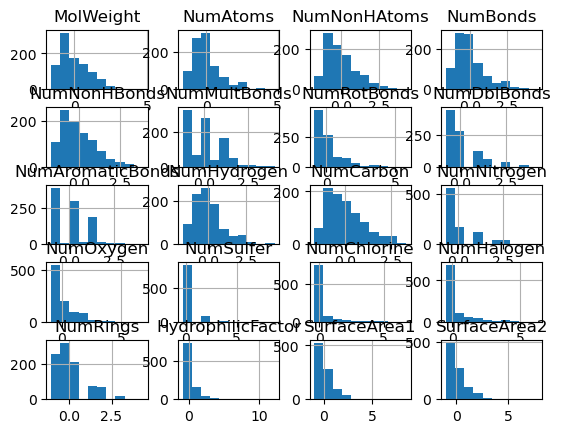

In [5]:
# plot continuous predictors to determine if they are normally distributed
# plots show that most are not noramlly distributed
# https://www.kaggle.com/code/abhikuks/power-transformers-in-depth-understanding
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 

scalar = StandardScaler()

X_train_scaled = pd.DataFrame(scalar.fit_transform(X_train.loc[:,non_ind_colnames]) , columns=non_ind_colnames)
X_test_scaled = pd.DataFrame(scalar.transform(X_test.loc[:,non_ind_colnames]),columns=non_ind_colnames)
fig = X_train_scaled.hist(column=non_ind_colnames)

<div class="alert alert-block alert-info">
    <p style="margin-left: 25px;">
    <b><font size="5">Run Shapiro on Predictors To Show Difference from Normally Distr</font></b></p>
</div>

In [6]:
###################################################################
# Run shapiro test and determine how close p-value is to .05
# all 20 continuous predictors are not close to p = .05
##################################################################
# https://www.statology.org/normality-test-python/
# https://stackoverflow.com/questions/28924633/list-of-dictionaries-with-comprehension-in-python
# https://realpython.com/iterate-through-dictionary-python/
# https://realpython.com/python-flatten-list/

from scipy.stats import shapiro 
colnames = X_train.iloc[:,range(0,228,1)].columns
from scipy.stats import shapiro 

#make this example reproducible
np.random.seed(100)

swilks_results = [{x:float(shapiro(X_train[x]).pvalue)} for x in non_ind_colnames] 


unnormal = [[(k,v) for k,v in d.items() if v < .05] for d in swilks_results]
non_normal = [item for row in unnormal for item in row]
print('Total Non-Ind Predictors: ', len(non_ind_colnames), 'Non-Normal Predictors: ', len(non_normal))
non_normal


Total Non-Ind Predictors:  20 Non-Normal Predictors:  20


[('MolWeight', 1.6757053929667645e-20),
 ('NumAtoms', 1.8550958754538613e-23),
 ('NumNonHAtoms', 3.086509684431631e-19),
 ('NumBonds', 1.4695109201735986e-23),
 ('NumNonHBonds', 3.021298125359189e-19),
 ('NumMultBonds', 3.8192457126027754e-22),
 ('NumRotBonds', 5.094235166181144e-32),
 ('NumDblBonds', 5.850152530714358e-34),
 ('NumAromaticBonds', 2.574152824684908e-30),
 ('NumHydrogen', 3.95797289812877e-22),
 ('NumCarbon', 2.98887083588952e-19),
 ('NumNitrogen', 7.37295485133984e-38),
 ('NumOxygen', 2.059372063092582e-31),
 ('NumSulfer', 0.0),
 ('NumChlorine', 0.0),
 ('NumHalogen', 5.885453550164232e-44),
 ('NumRings', 1.528922212325151e-27),
 ('HydrophilicFactor', 4.620515103091231e-37),
 ('SurfaceArea1', 1.4707654113511e-28),
 ('SurfaceArea2', 2.222946667817641e-27)]

<div class="alert alert-block alert-info">
    <p style="margin-left: 25px;">
    <b><font size="5">Find Predictors With Values Not > 0 In Preperartion for BoxCox</font></b></p>
</div>

In [7]:
X_train.loc[:,non_ind_colnames].describe()
#X_test.loc[:,non_ind_colnames].describe()

,MolWeight,NumAtoms,NumNonHAtoms,NumBonds,NumNonHBonds,NumMultBonds,NumRotBonds,NumDblBonds,NumAromaticBonds,NumHydrogen,NumCarbon,NumNitrogen,NumOxygen,NumSulfer,NumChlorine,NumHalogen,NumRings,HydrophilicFactor,SurfaceArea1,SurfaceArea2
count,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000
mean,199.453642,25.073684,12.977895,25.482105,13.386316,6.240000,2.126316,0.958947,5.260000,12.095789,9.821053,0.782105,1.518947,0.137895,0.547368,0.702105,1.408421,-0.038841,35.474516,38.587032
std,95.553730,12.126174,6.284319,12.970226,7.341384,5.186235,2.388690,1.188901,5.291979,7.097714,5.167743,1.175754,1.675824,0.443826,1.399747,1.482847,1.281107,1.111006,34.699453,37.227946
min,46.090000,5.000000,2.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.986000,0.000000,0.000000
25%,122.180000,17.000000,8.000000,17.000000,8.000000,1.000000,0.000000,0.000000,0.000000,7.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.767000,8.170000,9.230000
50%,174.025000,22.000000,11.000000,23.000000,12.000000,6.000000,1.500000,1.000000,6.000000,11.000000,9.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,-0.349000,26.300000,29.540000
75%,261.340000,30.000000,17.000000,31.000000,18.000000,11.000000,3.000000,1.000000,10.000000,15.000000,12.000000,1.000000,2.000000,0.000000,0.000000,1.000000,2.000000,0.325000,52.320000,55.840000
max,650.980000,83.000000,40.000000,85.000000,42.000000,27.000000,16.000000,6.000000,27.000000,43.000000,27.000000,6.000000,13.000000,4.000000,10.000000,10.000000,7.000000,13.483000,331.940000,331.940000


<div class="alert alert-block alert-info">
    <p style="margin-left: 25px;">
    <b><font size="5">Apply BoxCox Offsetting Data By 0.986001</font></b></p>
</div>

                 cols  box-cox_lambdas
0           MolWeight        -0.007062
1            NumAtoms         0.056922
2        NumNonHAtoms         0.071494
3            NumBonds         0.126459
4        NumNonHBonds         0.180224
5        NumMultBonds         0.369421
6         NumRotBonds        -0.135018
7         NumDblBonds        -0.668348
8    NumAromaticBonds         0.168731
9         NumHydrogen         0.337254
10          NumCarbon         0.284494
11        NumNitrogen        -1.428236
12          NumOxygen        -0.197465
13          NumSulfer       -11.480335
14        NumChlorine        -3.740806
15         NumHalogen        -2.526582
16           NumRings         0.034005
17  HydrophilicFactor         0.240048
18       SurfaceArea1         0.349650
19       SurfaceArea2         0.354745


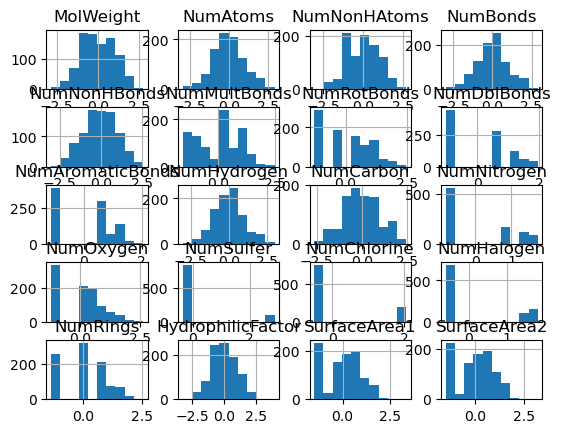

In [8]:
# run boxcox on continuous predcitos to bring closer to normal
# plot transformed data
# data plots are closer to normal_df
# https://machinelearningmastery.com/power-transforms-with-scikit-learn/
# https://www.digitalocean.com/community/tutorials/normalize-data-in-python
# transform and scale non indicator predictors
from pandas import DataFrame
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import PowerTransformer
from matplotlib import pyplot

# perform a box-cox transform of the dataset
pt = PowerTransformer(method = 'box-cox', standardize=True)
X_train_transformed = pt.fit_transform(X_train.loc[:,non_ind_colnames] + 0.986001)
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns = non_ind_colnames)  
X_test_transformed = pt.transform(X_test.loc[:,non_ind_colnames] + 0.98601)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns = non_ind_colnames)  
fig = X_train_transformed_df.hist(column=non_ind_colnames)
print(pd.DataFrame({'cols':X_train.loc[:,non_ind_colnames].columns , 'box-cox_lambdas': pt.lambdas_}))

<div class="alert alert-block alert-info">
    <p style="margin-left: 25px;">
    <b><font size="5">Merged Training Continuous Transformed and Indicator Variables Back Together</font></b></p>
</div>

In [9]:
# Merge Train indicator, continouos and outcome variables back together into dataframe
# https://www.statology.org/pandas-exclude-column/
X_train.reset_index(drop=True, inplace=True)
Y_train.reset_index(drop=True, inplace=True)
app_non_ind_colnames = non_ind_colnames.copy()
app_non_ind_colnames.append('Solubility')
ind_df = X_train.loc[:,~X_train.columns.isin(app_non_ind_colnames)]
#y_train = pd.DataFrame({'Solubility':Y_train})
X_train_trans = pd.concat([ind_df,X_train_transformed_df], axis=1)
print('ind: ', ind_df.shape, 'dataset: ', X_train_transformed_df.shape, 'new_trainX: ', X_train_trans.shape, 'original data: ', X_train.shape)
srange = list(range(215,225,1))
print(X_train_trans.iloc[1:3,srange])
#transformed_data.iloc[[1,2],srange]

ind:  (950, 208) dataset:  (950, 20) new_trainX:  (950, 228) original data:  (950, 228)
   NumDblBonds  NumAromaticBonds  NumHydrogen  NumCarbon  NumNitrogen  \
1     0.506297          0.500643    -0.671468  -0.434961     0.895450   
2    -1.014441          1.059946    -0.878326  -0.434961     1.620602   

   NumOxygen  NumSulfer  NumChlorine  NumHalogen  NumRings  
1   0.641107   -0.34872    -0.504576   -0.616306 -0.092913  
2  -1.203264    2.86742    -0.504576   -0.616306  0.666668  


<div class="alert alert-block alert-info">
    <p style="margin-left: 25px;">
    <b><font size="5">Merged Test Continuous Transformed and Indicator Variables Back Together</font></b></p>
</div>

In [10]:
# Merge Test indicator, continouos and outcome variables back together into dataframe
# https://www.statology.org/pandas-exclude-column/
X_test.reset_index(drop=True, inplace=True)
Y_test.reset_index(drop=True, inplace=True)
#non_ind_colnames.append('Solubility')
test_ind_df = X_test.loc[:,~X_test.columns.isin(app_non_ind_colnames)]
#y_test = pd.DataFrame({'Solubility':Y_test})
X_test_trans = pd.concat([test_ind_df,X_test_transformed_df], axis=1)
print('ind: ', test_ind_df.shape, 'dataset: ', X_test_transformed_df.shape, 'new_trainX: ', X_test_trans.shape, 'original data: ', X_test.shape)

srange = list(range(215,228,1))
X_test_trans.iloc[1:3,srange]


ind:  (317, 208) dataset:  (317, 20) new_trainX:  (317, 228) original data:  (317, 228)


,NumDblBonds,NumAromaticBonds,NumHydrogen,NumCarbon,NumNitrogen,NumOxygen,NumSulfer,NumChlorine,NumHalogen,NumRings,HydrophilicFactor,SurfaceArea1,SurfaceArea2
1,0.506305,0.500645,0.016696,0.007421,1.333126,0.641111,-0.348383,1.875111,1.407040,-0.092905,0.353131,0.492282,0.412653
2,-1.014416,1.806005,0.163994,1.447699,1.333126,-1.203247,-0.348383,-0.504488,-0.616249,1.636681,-1.167073,0.084192,0.015550


<div class="alert alert-block alert-info">
    <p style="margin-left: 25px;">
    <b><font size="5">Common Functions Used to Calculate Performance Measurements</font></b></p>
</div>   

In [11]:
len(X_test_trans)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def calc_errors(X, y, model):
    '''returns in-sample error for already fit model.'''
    temp_list = []
    predictions = model.predict(X)
    rsquared, rmse, mse, residuals = calc_performance(y, predictions)
    temp_list.append(rsquared)
    temp_list.append(rmse)
    temp_list.append(mse)
    temp_list.append(list(predictions))
    temp_list.append(residuals)
    return temp_list

def calc_performance(y, preds):
    temp_list = []
    rsquared = r2_score(y, preds)
    temp_list.append(rsquared)
    mse = mean_squared_error(y, preds)
    rmse = np.sqrt(mse)
    temp_list.append(rmse)
    temp_list.append(mse)
    residuals = list(preds - y) 
    temp_list.append(residuals)
    return temp_list

def calc_metrics(X_train, y_train, X_test, y_test, model):
    '''fits model and returns the RMSE for in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_errors(X_train, y_train, model)
    validation_error = calc_errors(X_test, y_test, model)
    return train_error, validation_error

<div class="alert alert-block alert-info">
    <p style="margin-left: 25px;">
    <b><font size="5">Perform Ordinally Linear regression</font></b></p><br>
    <font size="3">
         <ol>
          <li>Build Model on Training</li> 
          <li>Generate Predictions and Performance Results for Training and Test</li>
          <li>Run Cross Validation   
          <li>Assess Linear Assumptions using Residuals</li>
         </ol> </font>
</div>

In [12]:
# Using statsmodel class
# Build model on training and predict on test data
# https://www.statology.org/sklearn-linear-regression-summary/
import statsmodels.api as sm

#define response variable
sm_train_y = pd.DataFrame(Y_train)
sm_test_y = pd.DataFrame(Y_test)

#define predictor variables
sm_train_x = X_train_trans.copy()
sm_test_x = X_test_trans.copy()

#add constant to predictor variables
sm_train_x = sm.add_constant(sm_train_x)
sm_test_x = sm.add_constant(sm_test_x)

#fit linear regression model
sm_model = sm.OLS(sm_train_y, sm_train_x).fit()

sm_train_preds = sm_model.predict()
R2_train, RMSE_train, MSE_train, resids_train = calc_performance(Y_train, sm_train_preds)

print('Train Data Performance ','R2: ', R2_train, 'RMSE: ', RMSE_train, 'MSE: ', MSE_train)  
sm_test_preds = sm_model.predict(sm_test_x)
R2_test, RMSE_test, MSE_test, resids_test = calc_performance(Y_test, sm_test_preds)
print('Test Data Performance ','R2: ', R2_test, 'RMSE: ',RMSE_test, 'MSE: ',MSE_test)  

olsTrValues = pd.DataFrame(data={'obs': Y_train, 'pred' : sm_train_preds, 'resid' : resids_train})
# calc standardizesd residuals
rmean = olsTrValues["resid"].mean()
rstd = olsTrValues["resid"].std()
olsTrValues["sresid"] = (olsTrValues["resid"] - rmean)/rstd

olsTrValues[1:5]

Train Data Performance  R2:  0.9410614801956001 RMSE:  0.49920539531090535 MSE:  0.24920602670751726
Test Data Performance  R2:  0.8601742520204165 RMSE:  0.7643708271172501 MSE:  0.5842627613479091


,obs,pred,resid,sresid
1,-0.40,-1.065455,-0.665455,-1.332327
2,-1.55,-1.452672,0.097328,0.194862
3,-4.06,-3.973642,0.086358,0.172899
4,-1.77,-1.179370,0.590630,1.182518


<div class="alert alert-block alert-info">
    <p style="margin-left: 50px;">
    <b><font size="5">Run Cross Validation</font></b><br>
        <font size="3">- Estimating Expected Performance from Predicting New Data</font>
    </p>    
</div> 


In [13]:
# Cross validation on OLS Model
import numpy as np
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import KFold
#import sklearn.linear_model as skl_lm
import statsmodels.api as sm
import statsmodels.formula.api as smf
#from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

K = 10

cv_scores_indx = 0
cv_scores1 = pd.DataFrame(columns = ['fold', 'r2', 'rmse', 'mse'])

#train_errors2 = []
#validation_errors2 = []
#ols = skl_lm.LinearRegression()
kf = KFold(n_splits=K, shuffle=True, random_state=100).split(X_train_trans, Y_train)
for k, (train_index, val_index) in enumerate(kf):
#    scores = []
    cv_train_y = Y_train.iloc[train_index]
    cv_train_X = sm.add_constant(X_train_trans.iloc[train_index])
    cv_val_y = Y_train.iloc[val_index]
    cv_val_X = sm.add_constant(X_train_trans.iloc[val_index])
    smcv_model = sm.OLS(cv_train_y, cv_train_X).fit()
    smcv_results = calc_errors(cv_val_X, cv_val_y, smcv_model)
    cv_scores1.loc[k + cv_scores_indx] = [k, smcv_results[0], smcv_results[1], smcv_results[2]]  
    cv_scores_indx += 1

print('CV Validation performance ')    
print('R2 score: %.5f +/- %.5f' % (np.mean(cv_scores1['r2']), np.std(cv_scores1['r2'])))
print('RMSE score: %.5f +/- %.5f' % (np.mean(cv_scores1['rmse']), np.std(cv_scores1['rmse'])))
print('MSE score: %.5f +/- %.5f' % (np.mean(cv_scores1['mse']), np.std(cv_scores1['mse'])))
print('\n\tFold Scores Table\n')
cv_scores1.head(10)

CV Validation performance 
R2 score: 0.859 +/- 0.044
RMSE score: 0.752 +/- 0.118
MSE score: 0.580 +/- 0.187

	Fold Scores Table



,fold,r2,rmse,mse
0,0.0,0.860846,0.798760,0.638017
2,1.0,0.812882,0.896819,0.804284
4,2.0,0.756692,0.987004,0.974177
6,3.0,0.850399,0.611688,0.374162
8,4.0,0.916991,0.626145,0.392057
10,5.0,0.898073,0.739691,0.547143
12,6.0,0.873803,0.647452,0.419194
14,7.0,0.875194,0.699718,0.489605
16,8.0,0.852513,0.834172,0.695843
18,9.0,0.895248,0.680398,0.462942


In [14]:
%%html
<style>
#div1 + table {float:center; width:100%;}
#div1 + table tbody th {float:center; color:black; border: 1px black solid !important; color: black !important;}
#div1 + table tbody tr {float:center; color:blue;}
#div1 + table tbody td {border: 1px black solid !important; color: green !important;}
<\style>

<div class="alert alert-block alert-info">
    <p style="margin-left: 25px;">
    <b><font size="5">Comparing OLS Performance Across Train, Test , and CV</font></b></p>
</div>

<div id ="div1"></div>

|  Case                |  R2          |   RMSE       |    MSE    |         
|:-----------------:|:-:|:-: |:-:|  
|  OLS CV              |  0.868       |   0.720      |    0.524  |         
|  OLS Full Train      |  0.943       |   0.499      |    0.240  |         
|  OLS Test            |  0.871       |   0.746      |    0.557  |  
    

<div class="alert alert-block alert-info">
    <p style="margin-left: 25px;">
    <b><font size="5">Assess Linear Assumptions Graphically</font></b></p>
</div>

(array([  4.,  20.,  75., 220., 283., 204., 101.,  34.,   7.,   2.]),
 array([-3.39457698, -2.65686218, -1.91914738, -1.18143258, -0.44371778,
         0.29399702,  1.03171181,  1.76942661,  2.50714141,  3.24485621,
         3.98257101]),
 <BarContainer object of 10 artists>)

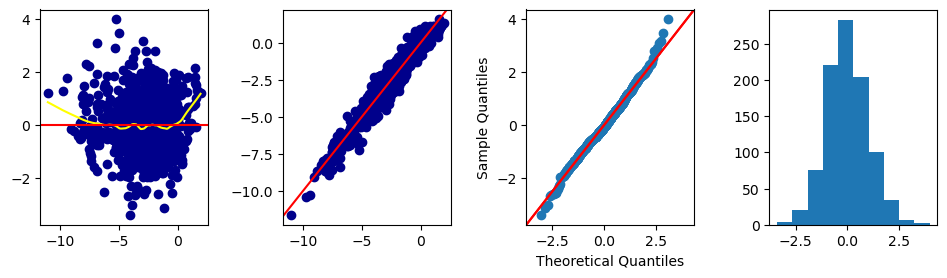

In [15]:
# https://www.kaggle.com/code/gadaadhaarigeek/q-q-plot
import statsmodels.api as sm 
#import pylab as py 
figure, axis = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
figure.tight_layout(pad=2.0)
axis[0].scatter(x=olsTrValues['pred'], y=olsTrValues['sresid'], c='DarkBlue')
smoothed = sm.nonparametric.lowess(exog=olsTrValues['pred'], endog=olsTrValues['sresid'], frac=0.2)
axis[0].plot(smoothed[:, 0], smoothed[:, 1], c="yellow")
axis[0].axhline(y = 0, color = 'red', linestyle = '-') 
axis[1].scatter(x=olsTrValues['pred'], y=olsTrValues['obs'], c='DarkBlue')
axis[1].axline((0,0), slope = 1, color = "red")
#plt.axline((1,2),slope=slope)
sm.qqplot(olsTrValues['sresid'], line='45', ax = axis[2])
axis[2].axline((0,0), slope = 1, color = "red")
axis[3].hist(x=olsTrValues['sresid'],bins=10)
#ax4.xlim([-2,2])
#plt.ylim([-3, 3])
#plt.yticks(np.arange(-2, 3, 0.5))
#plt.xticks(np.arange(-2, 2, 0.25))
#plt.show() 

<div class="alert alert-block alert-info">
    <p style="margin-left: 25px;">
    <b><font size="5">Assess Linear Assumptions with Statistical Tests</font></b></p>
</div>

In [16]:
# Statistical Tests
# https://www.geeksforgeeks.org/how-to-perform-a-breusch-pagan-test-in-python/
# https://www.statology.org/durbin-watson-t
# https://towardsdatascience.com/comparing-sample-distributions-with-the-kolmogorov-smirnov-ks-test-a2292ad6fee5

import statsmodels.formula.api as smf
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
import scipy.stats as stats
from statsmodels.stats.stattools import durbin_watson

# Since this is within the range of 1.5 and 2.5, 
#      we would consider autocorrelation not to be problematic in this regression model.

# Calculate mean of residuals
print('mean of residuals is : ', mean(olsTrValues['resid']))

# Kolmogorov-Smirnov Test
ks_norm_a = stats.ks_1samp(x = olsTrValues['resid'], cdf = stats.norm.cdf)

#Breusch-Pagan Test
names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test_result = sms.het_breuschpagan(olsTrValues['resid'], sm_train_x)
print('\nBP results: ', 'lagrange stat: ', test_result[0], 'P-value: ', test_result[1], '\n\t\tF-value: ', test_result[2], 'F P-value: ', test_result[3])

#perform Durbin-Watson test
print('\n durbin watson\t', durbin_watson(sm_model.resid))


mean of residuals is :  -1.2973575430327113e-13

BP results:  lagrange stat:  313.39103230532066 P-value:  0.00014911610094742777 
		F-value:  1.5657598527921683 F P-value:  7.227058447517e-06

 durbin watson	 2.0193011716786784


<div class="alert alert-block alert-info">
    <p style="margin-left: 25px;">
    <b><font size="5">Perform Lasso Regression</font></b></p><br>
    <font size="3">
         <ol>
          <li>Run Cross Validation to Do Hyperparameter Tuning      
          <li>Build Model on Training</li> 
          <li>Generate Predictions and Performance Results for Training and Test</li>
          <li>Run Cross Validation   
          <li>Assess Linear Assumptions using Residuals</li>
         </ol> </font>
</div>

<div class="alert alert-block alert-info">
    <p style="margin-left: 50px;">
    <b><font size="5">Run Cross Validation for Hyperparameter Tuning</font></b><br>
    </p>    
</div>

In [17]:
# Build list for Alpha parameter

def drange(x, y, jump):
  while x < y:
    yield float(x)
    x += float(jump)
    
alphas = [round(x,4) for x in drange(0.0005, 0.021, 0.0005)]
print(alphas)
len(alphas)

[0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.0055, 0.006, 0.0065, 0.007, 0.0075, 0.008, 0.0085, 0.009, 0.0095, 0.01, 0.0105, 0.011, 0.0115, 0.012, 0.0125, 0.013, 0.0135, 0.014, 0.0145, 0.015, 0.0155, 0.016, 0.0165, 0.017, 0.0175, 0.018, 0.0185, 0.019, 0.0195, 0.02, 0.0205]


41

In [18]:
# Cross Validation using KFOLD
# https://dziganto.github.io/cross-validation/data%20science/machine%20learning/model%20tuning/python/Model-Tuning-with-Validation-and-Cross-Validation/
# https://stackoverflow.com/questions/67701679/key-error-none-of-int64index-dtype-int64-are-in-the-columns
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
# https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/

from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import KFold
#from sklearn.linear_model import Lasso
import statsmodels.api as sm

K = 10
kf = KFold(n_splits=K, shuffle=True, random_state=100)
cv_scores_indx = 0
cv_scores2 = pd.DataFrame(columns = ['alpha', 'Cycle', 'RSquared', 'RSquared_Std', 'RMSE', 'RMSE_Std','MSE', 'MSE_Std'])

for alpha in alphas:
    
    train_errors = []
    validation_errors = []
    
    # instantiate model
    #    lasso = Lasso(alpha=alpha, fit_intercept=True, random_state=100, max_iter=100000)
    
    for train_index, val_index in kf.split(X_train_trans, Y_train):
        
        # split data
        X_train, X_val = X_train_trans.iloc[train_index], X_train_trans.iloc[val_index]
        y_train, y_val = Y_train.iloc[train_index], Y_train.iloc[val_index]

        sm_lasso = sm.OLS(endog=y_train, exog=sm.add_constant(X_train))\
                     .fit_regularized(method="elastic_net", alpha=alpha, L1_wt=1.0)
        
        #calculate errors
        
        train_error = calc_errors(sm.add_constant(X_train), y_train, sm_lasso)
        val_error = calc_errors(sm.add_constant(X_val), y_val, sm_lasso)
        
        
        # append to appropriate listvalidvalid
        train_errors.append(train_error)
        validation_errors.append(val_error)
    
    #print('index: ', cv_scores_indx)
       
    cv_scores2.loc[cv_scores_indx] = [alpha, 'train',  
                                     np.mean([x[0] for x in train_errors]),
                                     np.std([x[0] for x in train_errors]),
                                     np.mean([x[1] for x in train_errors]),
                                     np.std([x[1] for x in train_errors]),
                                     np.mean([x[2] for x in train_errors]),
                                     np.std([x[2] for x in train_errors])]
    
    cv_scores_indx += 1
    
    # print('val index: ', cv_scores_indx)
    cv_scores2.loc[cv_scores_indx] = [alpha, 'validate', 
                                     np.mean([x[0] for x in validation_errors]),
                                     np.std([x[0] for x in validation_errors]),
                                     np.mean([x[1] for x in validation_errors]),
                                     np.std([x[1] for x in validation_errors]),
                                     np.mean([x[2] for x in validation_errors]),
                                     np.std([x[2] for x in validation_errors])]
    cv_scores_indx += 1

cv_scores2[cv_scores2['Cycle'] == 'validate'].sort_values(by=['alpha']).head(10)

,alpha,Cycle,RSquared,RSquared_Std,RMSE,RMSE_Std,MSE,MSE_Std
1,0.0005,validate,0.869134,0.041048,0.723607,0.100036,0.533614,0.158736
3,0.0010,validate,0.873761,0.035040,0.711297,0.078642,0.512128,0.120913
5,0.0015,validate,0.876230,0.029747,0.706257,0.067141,0.503307,0.100373
7,0.0020,validate,0.877729,0.032020,0.700260,0.069898,0.495249,0.104047
9,0.0025,validate,0.877137,0.034330,0.700955,0.073670,0.496766,0.111080
11,0.0030,validate,0.874527,0.033329,0.708674,0.066792,0.506680,0.099671
13,0.0035,validate,0.876149,0.032796,0.704176,0.066570,0.500295,0.098723
15,0.0040,validate,0.875593,0.033523,0.705391,0.065148,0.501820,0.097158
17,0.0045,validate,0.874865,0.034973,0.706912,0.070610,0.504710,0.104372
19,0.0050,validate,0.872779,0.033301,0.714091,0.070191,0.514853,0.104408


<div class="alert alert-block alert-info">
    <p style="margin-left: 50px;">
    <b><font size="5">Plot Alpha vs RMSE</font></b><br>
    </p>    
</div> 


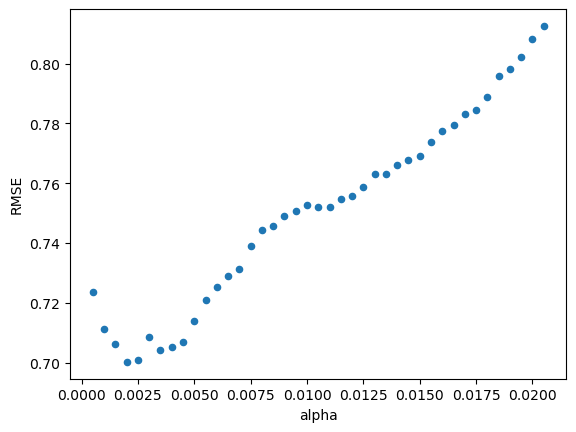

In [19]:
import matplotlib.pyplot as plt
import numpy as np
cv_scores2[cv_scores2['Cycle']== 'validate'].plot.scatter(x='alpha', y='RMSE')
plt.show()

<div class="alert alert-block alert-info">
    <p style="margin-left: 50px;">
    <b><font size="5">Alternate Cross Validation Approach That Was Not Used</font></b><br>
    </p>    
</div> 


In [ ]:
# Alternate Cross Validation Approach that was not used here. 
import numpy as np
from numpy import mean
from numpy import std
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

K = 10

cv_scores_indx = 0
cv_scores9 = pd.DataFrame(columns = ['alpha', 'fold', 'class_length', 'score', 'r2', 'rmse', 'mse'])
for alpha in alphas:
    train_errors2 = []
    validation_errors2 = []
    kf = KFold(n_splits=K, shuffle=True, random_state=100).split(X_train_trans, Y_train)
    for k, (train_index, val_index) in enumerate(kf):
        scores = []
        lasso = Lasso(alpha=alpha, fit_intercept=True, random_state=100, max_iter=100000)
        lasso.fit(X_train_trans.iloc[train_index], Y_train.iloc[train_index])
        preds = lasso.predict(X_train_trans.iloc[val_index])
        r2 = r2_score(Y_train.iloc[val_index], preds)
        mse = mean_squared_error(Y_train.iloc[val_index], preds)
        rmse = np.sqrt(mse)
        score = lasso.score(X_train_trans.iloc[val_index], Y_train.iloc[val_index])
        scores.append(score)
        #print('\nAlpha: %.4f, CV score: %.3f +/- %.3f' % (alpha,  np.mean(scores), np.std(scores)))
        cv_scores9.loc[k + cv_scores_indx] = [alpha, k, len(Y_train.iloc[val_index]), score, r2, rmse, mse]  
    cv_scores_indx += 10
#print('\nCV score: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
lassoCV_scores = cv_scores9.groupby('alpha').agg({'r2': ['mean', 'std'], 'rmse': ['mean', 'std'],
                                 'mse': ['mean', 'std']})
lassoCV_scores.reset_index(inplace=True)
lassoCV_scores.columns = ['Alpha', 'RSquared_mean', 'RSquared_std', 'RMSE_mean', 'RMSE_std', 'MSE_mean', 'MSE_std']
lassoCV_scores.head(10)

<div class="alert alert-block alert-info">
    <p style="margin-left: 50px;">
    <b><font size="5">Alternate Cross Validation Approach That Was Not Used</font></b><br>
    </p>    
</div> 

In [ ]:
# Alternate Cross Validation Approach that was not used here. 
# use GRIDSEARCHCV 
from numpy import arange
from pandas import read_csv
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
# load the dataset
#data = dataframe.values
X, y = X_train_trans.values, Y_train.values
# define model evaluation method
model = Lasso(max_iter=100000)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=100)
grid = dict()
grid['alpha'] = alphas
gscoring = ['neg_mean_squared_error', 'neg_root_mean_squared_error']
search = GridSearchCV(model, grid, scoring=gscoring,refit="neg_root_mean_squared_error",cv=cv,n_jobs=-1)
# fit model
l2model=search.fit(X, y)
# summarize chosen configuration
print('Best Results')
print('RMSE: %.3f   Alpha: %s' % (l2model.best_score_,l2model.best_params_['alpha']))
print('\n\nCV Results by Alpha')
cv_scores3 = pd.DataFrame(data = {'alpha': l2model.param_grid['alpha'],
                                  'RMSE': abs(l2model.cv_results_['mean_test_neg_root_mean_squared_error']),
                                  'RMSE_Std': abs(l2model.cv_results_['std_test_neg_root_mean_squared_error']),
                                  'MSE': abs(l2model.cv_results_['mean_test_neg_mean_squared_error']),
                                  'MSE_Std': abs(l2model.cv_results_['std_test_neg_mean_squared_error'])}) 
cv_scores3[1:10]

<div class="alert alert-block alert-info">
    <p style="margin-left: 50px;">
    <b><font size="5">Build Model on Full X-train Data</font></b><br><br>
    <b><font size="5">Generate Both Train and Test Performance Statistics</font></b>
    </p>    
</div> 

In [20]:
# Using statsmodel class
# Build model on training and predict on test data
# https://www.statology.org/sklearn-linear-regression-summary/
import statsmodels.api as sm

sm_lasso = sm.OLS(endog=Y_train, exog=sm.add_constant(X_train_trans))\
             .fit_regularized(method="elastic_net", alpha=0.0040, L1_wt=1.0)
        
#calculate errors
        
sm_lasso_train_preds = sm_lasso.predict()
R2_train, RMSE_train, MSE_train, lasso_resids_train = calc_performance(Y_train, sm_lasso_train_preds)
print('Train Data Performance ','R2: ', R2_train, 'RMSE: ', RMSE_train, 'MSE: ', MSE_train)  

sm_test_preds = sm_lasso.predict(sm.add_constant(X_test_trans))
R2_test, RMSE_test, MSE_test, lasso_resids_test = calc_performance(Y_test, sm_test_preds)
print('Test Data Performance ','R2: ', R2_test, 'RMSE: ',RMSE_test, 'MSE: ',MSE_test)  

lassoTrValues = pd.DataFrame(data={'obs': Y_train, 'pred' : sm_lasso_train_preds, 'resid' : lasso_resids_train})
# calc standardizesd residuals
rmean = lassoTrValues["resid"].mean()
rstd = lassoTrValues["resid"].std()
lassoTrValues["sresid"] = (lassoTrValues["resid"] - rmean)/rstd

lassoTrValues[1:5]

Train Data Performance  R2:  0.9077645582684483 RMSE:  0.6244944371524174 MSE:  0.38999330203431454
Test Data Performance  R2:  0.8844080528222107 RMSE:  0.6949832180148453 MSE:  0.48300167332226995


,obs,pred,resid,sresid
1,-0.40,-0.984933,-0.584933,-0.940806
2,-1.55,-1.936255,-0.386255,-0.622828
3,-4.06,-3.884189,0.175811,0.276741
4,-1.77,-1.044216,0.725784,1.156956


<div class="alert alert-block alert-info">
    <p style="margin-left: 25px;">
    <b><font size="5">Comparing Lasso Performance Across Train, Test , and CV</font></b></p>
</div>

<div id ="div1"></div>

|  Case                |  R2          |   RMSE       |    MSE    |         
|:-----------------:|:-:|:-: |:-:|  
|  LASSO CV              |  0.878       |   0.700      |    0.495  |         
|  LASSO Full Train      |  0.908       |   0.625      |    0.390  |         
|  LASSO Test            |  0.884       |   0.695      |    0.483  |      

<div class="alert alert-block alert-info">
    <p style="margin-left: 25px;">
    <b><font size="5">Assess Linear Assumptions Graphically</font></b></p>
</div>

(array([  2.,  22.,  64., 244., 324., 187.,  84.,  16.,   5.,   2.]),
 array([-2.23655802, -1.73661021, -1.2366624 , -0.73671459, -0.23676678,
         0.26318103,  0.76312884,  1.26307665,  1.76302447,  2.26297228,
         2.76292009]),
 <BarContainer object of 10 artists>)

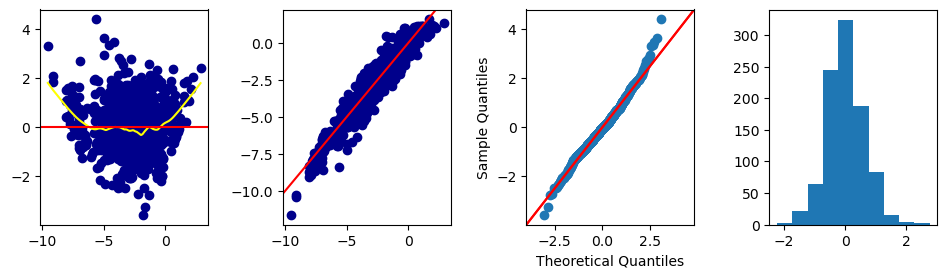

In [21]:
# https://www.kaggle.com/code/gadaadhaarigeek/q-q-plot
import statsmodels.api as sm 
#import pylab as py 
figure, axis = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
figure.tight_layout(pad=2.0)
axis[0].scatter(x=lassoTrValues['pred'], y=lassoTrValues['sresid'], c='DarkBlue')
smoothed = sm.nonparametric.lowess(exog=lassoTrValues['pred'], endog=lassoTrValues['sresid'], frac=0.2)
axis[0].plot(smoothed[:, 0], smoothed[:, 1], c="yellow")
axis[0].axhline(y = 0, color = 'red', linestyle = '-') 
axis[1].scatter(x=lassoTrValues['pred'], y=lassoTrValues['obs'], c='DarkBlue')
axis[1].axline((0,0), slope = 1, color = "red")
#plt.axline((1,2),slope=slope)
sm.graphics.qqplot(lassoTrValues['sresid'], line='45', ax = axis[2])
axis[2].axline((0,0), slope = 1, color = "red")
axis[3].hist(x=lassoTrValues['resid'],bins=10)
#ax4.xlim([-2,2])
#plt.ylim([-3, 3])
#plt.yticks(np.arange(-2, 3, 0.5))
#plt.xticks(np.arange(-2, 2, 0.25))
#plt.show() 

<div class="alert alert-block alert-info">
    <p style="margin-left: 25px;">
    <b><font size="5">Assess Linear Assumptions with Statistical Tests</font></b></p>
</div>

In [22]:
# Statistical Tests
# https://www.geeksforgeeks.org/how-to-perform-a-breusch-pagan-test-in-python/
# https://www.statology.org/durbin-watson-t
# https://towardsdatascience.com/comparing-sample-distributions-with-the-kolmogorov-smirnov-ks-test-a2292ad6fee5

import statsmodels.formula.api as smf
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
import scipy.stats as stats
from statsmodels.stats.stattools import durbin_watson

# Since this is within the range of 1.5 and 2.5, 
#      we would consider autocorrelation not to be problematic in this regression model.

# Calculate mean of residuals
print('mean of residuals is : ', mean(lassoTrValues['resid']))

# Kolmogorov-Smirnov Test
ks_norm_a = stats.ks_1samp(x = lassoTrValues['resid'], cdf = stats.norm.cdf)

#Breusch-Pagan Test
names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test_result = sms.het_breuschpagan(lassoTrValues['resid'], sm.add_constant(X_train_trans))
print('\nBP results: ', 'lagrange stat: ', test_result[0], 'P-value: ', test_result[1], '\n\t\tF-value: ', test_result[2], 'F P-value: ', test_result[3])

#perform Durbin-Watson test
print('\n durbin watson\t', durbin_watson(lassoTrValues['resid']))


mean of residuals is :  0.0028984710574708967

BP results:  lagrange stat:  380.4819482398105 P-value:  9.461965724262811e-10 
		F-value:  2.124897095241592 F P-value:  5.308172131547981e-14

 durbin watson	 2.034822184023763


<div class="alert alert-block alert-info">
    <p style="margin-left: 25px;">
    <b><font size="5">Perform Random Forest Regression</font></b></p><br>
    <font size="3">
         <ol>
          <li>Perform Cross Validation</li> 
          <li>Build Model on Training</li> 
          <li>Generate Predictions and Performance Results for Training and Test</li>
          <li>Run Cross Validation   
          <li>Assess Linear Assumptions using Residuals</li>
         </ol> </font>
</div>

In [ ]:
#Cross validation number of trees
# https://stackoverflow.com/questions/59678961/how-to-plot-the-error-and-the-tree-size-of-a-random-forest

<div class="alert alert-block alert-info">
    <p style="margin-left: 50px;">
    <b><font size="5">Run Cross Validation for Hyperparameter Tuning</font></b><br>
    </p>    
</div>

In [36]:
# Cross Validation using KFOLD
# https://dziganto.github.io/cross-validation/data%20science/machine%20learning/model%20tuning/python/Model-Tuning-with-Validation-and-Cross-Validation/
# https://stackoverflow.com/questions/67701679/key-error-none-of-int64index-dtype-int64-are-in-the-columns
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
# https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/

from numpy import mean
from numpy import std
from numpy import absolute
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor


K = 10
kf = KFold(n_splits=K, shuffle=True, random_state=100)
cv_scores_indx = 0
cv_scores3 = pd.DataFrame(columns = ['mtry', 'Cycle', 'RSquared', 'RSquared_Std', 'RMSE', 'RMSE_Std','MSE', 'MSE_Std', 
                                     'OOB_Error', 'OOB_Error_Std'])

for mtry in range(100,1001,2):
    
    train_errors = []
    validation_errors = []
    
    # instantiate model
    #    lasso = Lasso(alpha=alpha, fit_intercept=True, random_state=100, max_iter=100000)
    
    for train_index, val_index in kf.split(X_train_trans, Y_train):
        
        # split data
        X_train, X_val = X_train_trans.iloc[train_index], X_train_trans.iloc[val_index]
        y_train, y_val = Y_train.iloc[train_index], Y_train.iloc[val_index]

        rforest_model = RandomForestRegressor(n_estimators=mtry, max_features='sqrt', 
                                              n_jobs=-1, random_state=100, oob_score=True)\
                .fit(X_train_trans, Y_train)
        
        #calculate errors
        
        train_error = calc_errors(X_train, y_train, rforest_model)
        val_error = calc_errors(X_val, y_val, rforest_model)
        oob_error = 1 - rforest_model.oob_score_
        train_error.append(oob_error)
        
        
        
        # append to appropriate listvalidvalid
        train_errors.append(train_error)
        validation_errors.append(val_error)
    
    #print('index: ', cv_scores_indx)
       
    cv_scores3.loc[cv_scores_indx] = [mtry, 'train',  
                                     np.mean([x[0] for x in train_errors]),
                                     np.std([x[0] for x in train_errors]),
                                     np.mean([x[1] for x in train_errors]),
                                     np.std([x[1] for x in train_errors]),
                                     np.mean([x[2] for x in train_errors]),
                                     np.std([x[2] for x in train_errors]),
                                     np.mean([x[5] for x in train_errors]),
                                     np.std([x[5] for x in train_errors])]
    
    cv_scores_indx += 1
    
    # print('val index: ', cv_scores_indx)
    cv_scores3.loc[cv_scores_indx] = [mtry, 'validate', 
                                     np.mean([x[0] for x in validation_errors]),
                                     np.std([x[0] for x in validation_errors]),
                                     np.mean([x[1] for x in validation_errors]),
                                     np.std([x[1] for x in validation_errors]),
                                     np.mean([x[2] for x in validation_errors]),
                                     np.std([x[2] for x in validation_errors]), 0, 0]
    cv_scores_indx += 1

cv_scores3[cv_scores3['Cycle'] == 'validate'].sort_values(by=['MSE']).head(10)


,mtry,Cycle,RSquared,RSquared_Std,RMSE,RMSE_Std,MSE,MSE_Std,OOB_Error,OOB_Error_Std
225,324,validate,0.985186,0.003587,0.244282,0.024290,0.060264,0.012106,0.0,0.0
227,326,validate,0.985185,0.003592,0.244294,0.024303,0.060270,0.012109,0.0,0.0
237,336,validate,0.985183,0.003599,0.244305,0.024334,0.060277,0.012133,0.0,0.0
213,312,validate,0.985185,0.003583,0.244323,0.024291,0.060284,0.012126,0.0,0.0
423,522,validate,0.985177,0.003631,0.244334,0.024285,0.060289,0.012127,0.0,0.0
231,330,validate,0.985184,0.003589,0.244324,0.024583,0.060298,0.012257,0.0,0.0
217,316,validate,0.985181,0.003620,0.244311,0.024734,0.060300,0.012334,0.0,0.0
247,346,validate,0.985174,0.003624,0.244354,0.024311,0.060300,0.012117,0.0,0.0
543,642,validate,0.985189,0.003537,0.244395,0.023976,0.060304,0.012022,0.0,0.0
229,328,validate,0.985178,0.003593,0.244359,0.024420,0.060308,0.012170,0.0,0.0


In [79]:
cv_scores3[cv_scores3['mtry'] > 590].head(10)

,mtry,Cycle,RSquared,RSquared_Std,RMSE,RMSE_Std,MSE,MSE_Std,OOB_Error,OOB_Error_Std
492,592,train,0.985699,0.000322,0.245845,0.002739,0.060447,0.001342,0.103638,0.0
493,592,validate,0.985152,0.003549,0.244682,0.024043,0.060447,0.012076,0.000000,0.0
494,594,train,0.985708,0.000321,0.245769,0.002740,0.060410,0.001342,0.103599,0.0
495,594,validate,0.985162,0.003543,0.244604,0.024058,0.060410,0.012078,0.000000,0.0
496,596,train,0.985718,0.000321,0.245681,0.002732,0.060367,0.001338,0.103528,0.0
497,596,validate,0.985171,0.003548,0.244522,0.023995,0.060367,0.012038,0.000000,0.0
498,598,train,0.985720,0.000320,0.245672,0.002720,0.060362,0.001332,0.103547,0.0
499,598,validate,0.985172,0.003541,0.244521,0.023903,0.060362,0.011985,0.000000,0.0
500,600,train,0.985715,0.000320,0.245711,0.002722,0.060381,0.001333,0.103561,0.0
501,600,validate,0.985166,0.003551,0.244559,0.023923,0.060381,0.011999,0.000000,0.0


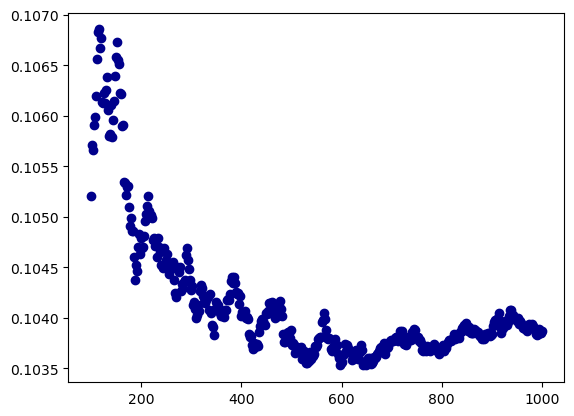

In [37]:
# Plot Trees vs Out Of Bag Error
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html
# https://www.analyticsvidhya.com/blog/2020/12/out-of-bag-oob-score-in-the-random-forest-algorithm/

cv_scores3[cv_scores3['Cycle'] == 'train'].sort_values(by=['MSE']).head(10)
dfw = cv_scores3[cv_scores3['Cycle'] == 'train']
plt.scatter(x=dfw['mtry'], y=dfw['OOB_Error'], c='DarkBlue')


<div class="alert alert-block alert-info">
    <p style="margin-left: 50px;">
    <b><font size="5">Plot Trees vs RMSE</font></b><br>
    </p>    
</div> 


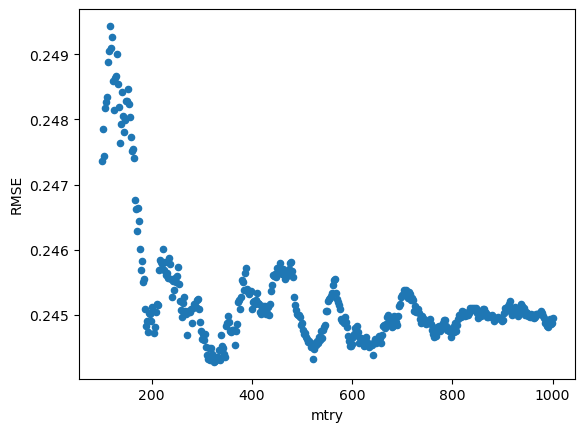

In [38]:
import matplotlib.pyplot as plt
import numpy as np
cv_scores3[cv_scores3['Cycle']== 'validate'].plot.scatter(x='mtry', y='RMSE')
plt.show()

In [75]:
cv_scores3[cv_scores3['Cycle'] == 'train'].sort_values(by=['OOB_Error']).head(5)

,mtry,Cycle,RSquared,RSquared_Std,RMSE,RMSE_Std,MSE,MSE_Std,OOB_Error,OOB_Error_Std
496,596,train,0.985718,0.000321,0.245681,0.002732,0.060367,0.001338,0.103528,0.0
542,642,train,0.985733,0.000319,0.245553,0.002730,0.060304,0.001336,0.103531,0.0
548,648,train,0.985711,0.000321,0.245741,0.002734,0.060396,0.001339,0.103534,0.0
558,658,train,0.985715,0.000319,0.245713,0.002698,0.060382,0.001322,0.103546,0.0
498,598,train,0.985720,0.000320,0.245672,0.002720,0.060362,0.001332,0.103547,0.0


<div class="alert alert-block alert-info">
    <p style="margin-left: 50px;">
    <b><font size="5">Build Model on Full X-train Data</font></b><br><br>
    <b><font size="5">Generate Both Train and Test Performance Statistics</font></b>
    </p>    
</div> 

In [40]:
# Using statsmodel class
# Build model on training and predict on test data
# https://www.statology.org/sklearn-linear-regression-summary/
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
rforest_model = RandomForestRegressor(n_estimators=596, max_features='sqrt', 
                                              n_jobs=-1, random_state=100, oob_score=True)\
                .fit(X_train_trans, Y_train)
  
rf_train_preds = rforest_model.predict(X_train_trans)
        
#calculate errors
        
R2_train, RMSE_train, MSE_train, rf_resids_train = calc_performance(Y_train, rf_train_preds)
print('Train Data Performance ','R2: ', R2_train, 'RMSE: ', RMSE_train, 'MSE: ', MSE_train)  

rf_test_preds = rforest_model.predict(X_test_trans)
R2_test, RMSE_test, MSE_test, rf_resids_test = calc_performance(Y_test, rf_test_preds)
print('Test Data Performance ','R2: ', R2_test, 'RMSE: ',RMSE_test, 'MSE: ',MSE_test)  

rfTrValues = pd.DataFrame(data={'obs': Y_train, 'pred' : rf_train_preds, 'resid' : rf_resids_train})
# calc standardizesd residuals
rmean = rfTrValues["resid"].mean()
rstd = rfTrValues["resid"].std()
rfTrValues["sresid"] = (rfTrValues["resid"] - rmean)/rstd

rfTrValues[1:5]

Train Data Performance  R2:  0.985722968147148 RMSE:  0.2456963033778891 MSE:  0.060366673493559724
Test Data Performance  R2:  0.8868645449144893 RMSE:  0.6875588744029976 MSE:  0.47273720577031697


,obs,pred,resid,sresid
1,-0.40,-0.771829,-0.371829,-1.504156
2,-1.55,-1.706915,-0.156915,-0.629873
3,-4.06,-4.056275,0.003725,0.023622
4,-1.77,-1.261812,0.508188,2.075812


<div class="alert alert-block alert-info">
    <p style="margin-left: 25px;">
    <b><font size="5">Variable (Feature) Importance Plot</font></b></p>
</div>

In [43]:
# Plot Feature Imporanc In order of Greatest Importance
# https://mljar.com/blog/feature-importance-in-random-forest/
sorted_idx = rforest_model.feature_importances_.argsort()
plt.barh(X_train_trans.feature_names[sorted_idx], rforest_model.feature_importances_[sorted_idx])
plt.xlabel("Solubility Random Forest Feature Importance")

AttributeError: 'DataFrame' object has no attribute 'feature_names'

In [47]:
X_train_trans.columns

Index(['FP001', 'FP002', 'FP003', 'FP004', 'FP005', 'FP006', 'FP007', 'FP008',
       'FP009', 'FP010',
       ...
       'NumCarbon', 'NumNitrogen', 'NumOxygen', 'NumSulfer', 'NumChlorine',
       'NumHalogen', 'NumRings', 'HydrophilicFactor', 'SurfaceArea1',
       'SurfaceArea2'],
      dtype='object', length=228)

In [49]:
from sklearn.inspection import permutation_importance
r = permutation_importance(rforest_model, X_train_trans, Y_train, n_repeats=30, random_state=100)

vif_scores = pd.DataFrame(columns = ['predictor', 'vif_score', 'vif_std'])
row_ct = 1
for i in r.importances_mean.argsort()[::-1]:
     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
         vif_scores.loc[row_ct] = [X_train_trans.columns[i], r.importances_mean[i], r.importances_std[i]]  
         row_ct += 1   

# barh dispays bars from bottom to top, so sort accordingly
dbx = vif_scores[0:15].sort_values(by='vif_score')
ax = dbx.plot.barh(x='predictor', y='vif_score')

MolWeight0.046 +/- 0.002
NumCarbon0.034 +/- 0.002
NumNonHBonds0.029 +/- 0.001
NumNonHAtoms0.028 +/- 0.001
SurfaceArea20.025 +/- 0.001
NumBonds0.023 +/- 0.001
SurfaceArea10.022 +/- 0.001
NumAtoms0.016 +/- 0.001
HydrophilicFactor0.015 +/- 0.001
NumAromaticBonds0.010 +/- 0.000
NumMultBonds0.010 +/- 0.000
NumHalogen0.009 +/- 0.000
FP076   0.008 +/- 0.000
NumHydrogen0.008 +/- 0.000
NumOxygen0.007 +/- 0.000
NumRings0.007 +/- 0.000
NumChlorine0.006 +/- 0.000
FP072   0.006 +/- 0.000
FP112   0.005 +/- 0.000
NumRotBonds0.005 +/- 0.000
FP009   0.005 +/- 0.000
FP092   0.004 +/- 0.000
NumNitrogen0.004 +/- 0.000
FP089   0.004 +/- 0.000
FP063   0.003 +/- 0.000
FP070   0.003 +/- 0.000
FP172   0.003 +/- 0.000
FP065   0.002 +/- 0.000
FP006   0.002 +/- 0.000
FP004   0.002 +/- 0.000
FP013   0.002 +/- 0.000
FP107   0.002 +/- 0.000
FP075   0.002 +/- 0.000
FP079   0.002 +/- 0.000
FP169   0.002 +/- 0.000
FP014   0.002 +/- 0.000
FP084   0.002 +/- 0.000
FP168   0.002 +/- 0.000
FP162   0.002 +/- 0.000
NumDblBond

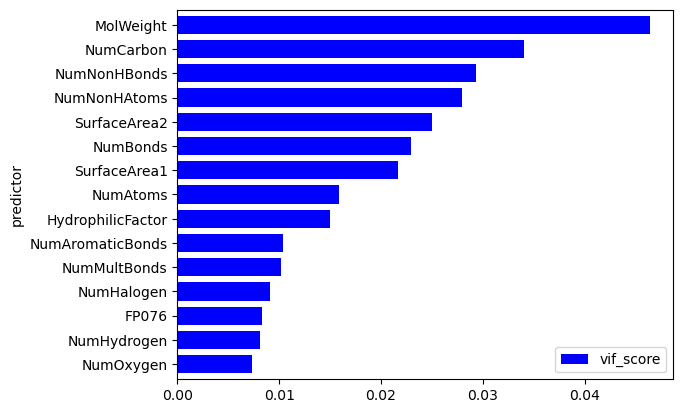

In [72]:
# barh dispays bars from bottom to top, so sort accordingly
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html
dbx = vif_scores[0:15].sort_values(by='vif_score')
ax = dbx.plot(kind='barh', x='predictor', y='vif_score', color='blue', width=0.75)

<div class="alert alert-block alert-info">
    <p style="margin-left: 25px;">
    <b><font size="5">OOB Errors per Number of Trees</font></b></p>
</div>

<div class="alert alert-block alert-info">
    <p style="margin-left: 25px;">
    <b><font size="5">Comparing Random Forest Performance Across Train, Test , and CV</font></b></p>
</div>

<div id ="div1"></div>

|  Case                     |  R2          |   RMSE       |    MSE    |         
|:-----------------:|:-:|:-: |:-:|  
|  RForest CV              |  0.985       |   0.245      |    0.060  |         
|  RForest Full Train      |  0.986       |   0.246      |    0.060  |         
|  RForest Test            |  0.887       |   0.688      |    0.473  |  

<div class="alert alert-block alert-info">
    <p style="margin-left: 25px;">
    <b><font size="5">Assess Linear Assumptions Graphically</font></b></p>
</div>

In [ ]:
# https://www.kaggle.com/code/gadaadhaarigeek/q-q-plot
import statsmodels.api as sm 
#import pylab as py 
figure, axis = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
figure.tight_layout(pad=2.0)
axis[0].scatter(x=rfTrValues['pred'], y=rfTrValues['sresid'], c='DarkBlue')
smoothed = sm.nonparametric.lowess(exog=rfTrValues['pred'], endog=rfTrValues['sresid'], frac=0.2)
axis[0].plot(smoothed[:, 0], smoothed[:, 1], c="yellow")
axis[0].axhline(y = 0, color = 'red', linestyle = '-') 
axis[1].scatter(x=rfTrValues['pred'], y=rfTrValues['obs'], c='DarkBlue')
axis[1].axline((0,0), slope = 1, color = "red")
#plt.axline((1,2),slope=slope)
sm.graphics.qqplot(rfTrValues['sresid'], line='45', ax = axis[2])
axis[2].axline((0,0), slope = 1, color = "red")
axis[3].hist(x=rfTrValues['resid'],bins=10)
#ax4.xlim([-2,2])
#plt.ylim([-3, 3])
#plt.yticks(np.arange(-2, 3, 0.5))
#plt.xticks(np.arange(-2, 2, 0.25))
#plt.show() 

<div class="alert alert-block alert-info">
    <p style="margin-left: 25px;">
    <b><font size="5">Assess Linear Assumptions with Statistical Tests</font></b></p>
</div>

In [ ]:
# Statistical Tests
# https://www.geeksforgeeks.org/how-to-perform-a-breusch-pagan-test-in-python/
# https://www.statology.org/durbin-watson-t
# https://towardsdatascience.com/comparing-sample-distributions-with-the-kolmogorov-smirnov-ks-test-a2292ad6fee5

import statsmodels.formula.api as smf 
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
import scipy.stats as stats
from statsmodels.stats.stattools import durbin_watson

# Since this is within the range of 1.5 and 2.5, 
#      we would consider autocorrelation not to be problematic in this regression model.

# Calculate mean of residuals
print('mean of residuals is : ', mean(rfTrValues['sresid']))

# Kolmogorov-Smirnov Test
ks_norm_a = stats.ks_1samp(x = rfTrValues['sresid'], cdf = stats.norm.cdf)

#Breusch-Pagan Test
names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
test_result = sms.het_breuschpagan(rfTrValues['sresid'], sm.add_constant(X_train_trans))
print('\nBP results: ', 'lagrange stat: ', test_result[0], 'P-value: ', test_result[1], '\n\t\tF-value: ', test_result[2], 'F P-value: ', test_result[3])

#perform Durbin-Watson test
print('\n durbin watson\t', durbin_watson(rfTrValues['sresid']))


<div class="alert alert-block alert-info">
    <p style="margin-left: 25px;">
    <b><font size="5">Plot and Compare Performance Across All Three Models</font></b></p>
</div>

In [90]:
#perfdata.colnames = ['Test', 'rs', 'rmse', 'mse']
rows = [{'Test':'OLS Train', 'rs': 0.942698, 'rmse':0.48966, 'mse':0.23977},
        {'Test':'OLS Test', 'rs': 0.8706649, 'rmse':0.7463009, 'mse':0.556965},
        {'Test':'OLS CV', 'rs': 0.868, 'rmse':0.720, 'mse':0.524},
        {'Test':'Lasso Train', 'rs': 0.9077645, 'rmse':0.6244944, 'mse':0.3899933},
        {'Test':'Lasso Test', 'rs': 0.8844080, 'rmse':0.6949832, 'mse':0.48300167},
        {'Test':'Lasso CV', 'rs': 0.877729, 'rmse':0.700260 , 'mse':0.495249},
        {'Test':'RForest Train', 'rs': 0.986, 'rmse':0.246, 'mse':0.0603},
        {'Test':'RForest Test', 'rs': 0.887, 'rmse':0.688, 'mse':0.473},
        {'Test':'RForest CV', 'rs': 0.984478, 'rmse':0.245420, 'mse':0.0603}]
perfdata = pd.DataFrame(data=rows, columns=['Test', 'rs', 'rmse', 'mse'])
perfdata

,Test,rs,rmse,mse
0,OLS Train,0.942698,0.489660,0.239770
1,OLS Test,0.870665,0.746301,0.556965
2,OLS CV,0.868000,0.720000,0.524000
3,Lasso Train,0.907764,0.624494,0.389993
4,Lasso Test,0.884408,0.694983,0.483002
5,Lasso CV,0.877729,0.700260,0.495249
6,RForest Train,0.986000,0.246000,0.060300
7,RForest Test,0.887000,0.688000,0.473000
8,RForest CV,0.984478,0.245420,0.060300


In [91]:
perfdata['rs'] = perfdata['rs'].astype(float)
perfdata['rmse'] = perfdata['rmse'].astype(float)
perfdata['mse'] = perfdata['mse'].astype(float)
perfdata

,Test,rs,rmse,mse
0,OLS Train,0.942698,0.489660,0.239770
1,OLS Test,0.870665,0.746301,0.556965
2,OLS CV,0.868000,0.720000,0.524000
3,Lasso Train,0.907764,0.624494,0.389993
4,Lasso Test,0.884408,0.694983,0.483002
5,Lasso CV,0.877729,0.700260,0.495249
6,RForest Train,0.986000,0.246000,0.060300
7,RForest Test,0.887000,0.688000,0.473000
8,RForest CV,0.984478,0.245420,0.060300


Text(0.5, 1.0, 'Test R2 Results by Model')

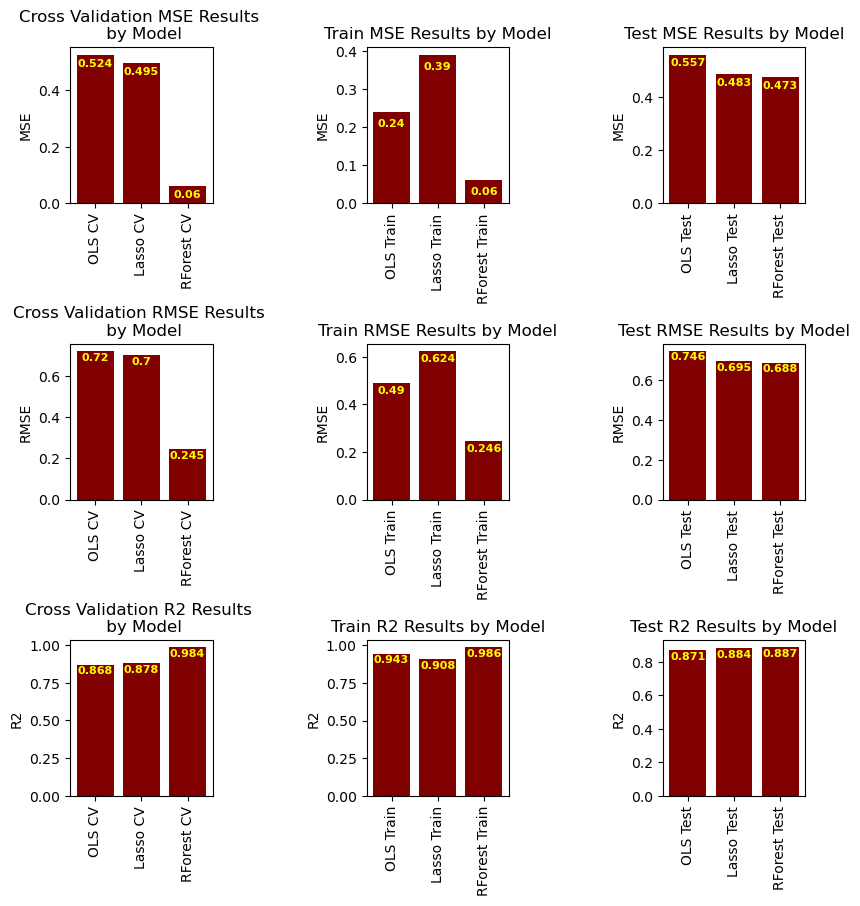

In [127]:
# https://stackoverflow.com/questions/40315878/a-convenient-way-to-plot-bar-plot-in-pandas]
from matplotlib import pyplot as plt
#data.Title.str.findall('[It].*')
dfa = perfdata[perfdata.Test.str.match('.*CV')]
dfb = perfdata[perfdata.Test.str.match('.*Train')]
dfc = perfdata[perfdata.Test.str.match('.*Test')]
figure, axis = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
figure.tight_layout(pad=8.0)

axis[0][0].bar(dfa['Test'], dfa['mse'], color ='maroon')
for tick in axis[0][0].get_xticklabels():
    tick.set_rotation(90)
axis[0][0].set_ylabel("MSE")
for i, v in enumerate(dfa['mse']):
    axis[0][0].text(i, v-0.03, str(round(v,3)), fontsize=8,fontweight='bold',
                    color = 'yellow', ha='center', va='center')

axis[0][0].set_title("Cross Validation MSE Results \n by Model")
axis[0][1].bar(dfb['Test'], dfb['mse'], color ='maroon')
for tick in axis[0][1].get_xticklabels():
    tick.set_rotation(90)
axis[0][1].set_ylabel("MSE")
for i, v in enumerate(dfb['mse']):
    axis[0][1].text(i, v-0.03, str(round(v,3)), fontsize=8,fontweight='bold',
                    color = 'yellow', ha='center', va='center')

axis[0][1].set_title("Train MSE Results by Model")
axis[0][2].bar(dfc['Test'], dfc['mse'], color ='maroon')
for tick in axis[0][2].get_xticklabels():
    tick.set_rotation(90)
axis[0][2].set_ylabel("MSE")
for i, v in enumerate(dfc['mse']):
    axis[0][2].text(i, v-0.03, str(round(v,3)), fontsize=8,fontweight='bold',
                    color = 'yellow', ha='center', va='center')

axis[0][2].set_title("Test MSE Results by Model")
axis[1][0].bar(dfa['Test'], dfa['rmse'], color ='maroon')
for tick in axis[1][0].get_xticklabels():
    tick.set_rotation(90)
axis[1][0].set_ylabel("RMSE")
for i, v in enumerate(dfa['rmse']):
    axis[1][0].text(i, v-0.03, str(round(v,3)), fontsize=8,fontweight='bold',
                    color = 'yellow', ha='center', va='center')

axis[1][0].set_title("Cross Validation RMSE Results \n by Model")
axis[1][1].bar(dfb['Test'], dfb['rmse'], color ='maroon')
for tick in axis[1][1].get_xticklabels():
    tick.set_rotation(90)
axis[1][1].set_ylabel("RMSE")
for i, v in enumerate(dfb['rmse']):
    axis[1][1].text(i, v-0.03, str(round(v,3)), fontsize=8,fontweight='bold',
                    color = 'yellow', ha='center', va='center')

axis[1][1].set_title("Train RMSE Results by Model")
axis[1][2].bar(dfc['Test'], dfc['rmse'], color ='maroon')
for tick in axis[1][2].get_xticklabels():
    tick.set_rotation(90)
axis[1][2].set_ylabel("RMSE")
for i, v in enumerate(dfc['rmse']):
    axis[1][2].text(i, v-0.03, str(round(v,3)), fontsize=8,fontweight='bold',
                    color = 'yellow', ha='center', va='center')

axis[1][2].set_title("Test RMSE Results by Model")
axis[2][0].bar(dfa['Test'], dfa['rs'], color ='maroon')
for tick in axis[2][0].get_xticklabels():
    tick.set_rotation(90)
axis[2][0].set_ylabel("R2")
for i, v in enumerate(dfa['rs']):
    axis[2][0].text(i, v-0.04, str(round(v,3)), fontsize=8,fontweight='bold',
                    color = 'yellow', ha='center', va='center')

axis[2][0].set_title("Cross Validation R2 Results \n by Model")
axis[2][1].bar(dfb['Test'], dfb['rs'], color ='maroon')
for tick in axis[2][1].get_xticklabels():
    tick.set_rotation(90)
axis[2][1].set_ylabel("R2")
for i, v in enumerate(dfb['rs']):
    axis[2][1].text(i, v-0.04, str(round(v,3)), fontsize=8,fontweight='bold',
                    color = 'yellow', ha='center', va='center')

axis[2][1].set_title("Train R2 Results by Model")
axis[2][2].bar(dfc['Test'], dfc['rs'], color ='maroon')
for tick in axis[2][2].get_xticklabels():
    tick.set_rotation(90)
axis[2][2].set_ylabel("R2")
for i, v in enumerate(dfc['rs']):
    axis[2][2].text(i, v-0.04, str(round(v,3)), fontsize=8,fontweight='bold',
                    color = 'yellow', ha='center', va='center')

axis[2][2].set_title("Test R2 Results by Model")

#dfa.plot.bar(x='Test', y='mse',ax = axis[1])
#        df[df["column_name"].str.contains(r'(?:\s|^)Gesamt(?:\s|$)')]]==True 